In [1]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import numpy as np

# apply fivethirtyeight style
# plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings('ignore')

In [2]:
master = json.load(open("data/annotation/master.json"))
le_annotators = ["bence","aske","mateusz","viktor","gustav"]

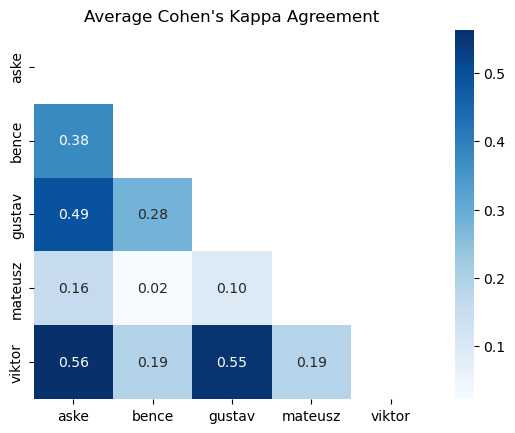

In [3]:
import pandas as pd
# Average cohens kappa agreement
annotators = [annotator for annotator in le_annotators]
collect_cohens = {annotator : defaultdict(list) for annotator in annotators}
cohens_scores = [master[entry]["inter-annotation-agreement"] for entry in master]

for overview in cohens_scores:

    for annotator_one in overview:
        for annotator_two in overview[annotator_one]:
    
            collect_cohens[annotator_one][annotator_two].append(overview[annotator_one][annotator_two])

# create empty pandas dataframe 
cohens_df = pd.DataFrame(index = sorted(annotators),columns=sorted(annotators))
for annotator_one in collect_cohens:
    for annotator_two in collect_cohens[annotator_one]:
        cohens_df.loc[annotator_one,annotator_two] = np.mean(collect_cohens[annotator_one][annotator_two])

# create a mask to hide the upper triangle
mask = np.zeros_like(cohens_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# fill cohens_df with 1 on nan
cohens_df.fillna(1, inplace=True)

# confusion matrix from cohens_df
sns.heatmap(cohens_df, annot=True, cmap="Blues", fmt=".2f", mask=mask)
plt.title("Average Cohen's Kappa Agreement")
plt.show()

Average Fleiss Kappa Agreement: -0.023


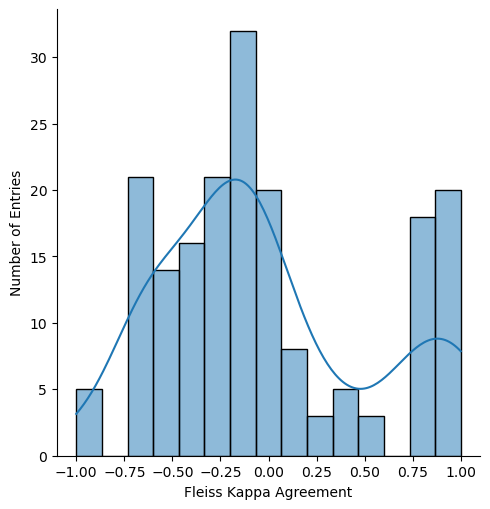

In [4]:
# Average fleiss kappa agreement and distribution plot
fleis_scores = [master[entry]["fleiss_kappa_score"] for entry in master]
valid_scores = [score for score in fleis_scores if not np.isnan(score)]
print(f"Average Fleiss Kappa Agreement: {np.mean(valid_scores):.3f}")
sns.displot(fleis_scores, kde=True, bins=15)
plt.xlabel("Fleiss Kappa Agreement")
plt.ylabel("Number of Entries")
plt.show()


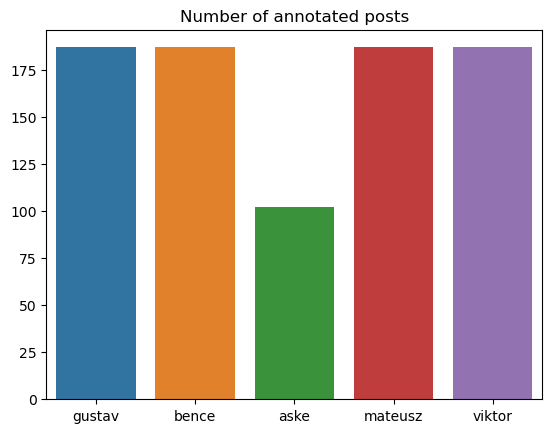

In [5]:
# Number of annotated posts
counts = defaultdict(int)
for entry in master:
    for annotator in master[entry]["annotations"]:
        counts[annotator] += 1

# Plot the number of annotated posts

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Number of annotated posts")
plt.show()


In [6]:
# Distribution of posts on dates and subreddit
import datetime

# init empty df
for_the_plot = pd.DataFrame(columns=["date","subreddit","count"])
subreddits = sorted(list(set([master[entry]["subreddit"] for entry in master])))
dates = sorted(list(set([datetime.datetime.strptime(master[entry]["date"], "%Y_%m_%d").date() for entry in master])))

for date in dates:
    # insert row for each subreddit with count 0 using concat
    for subreddit in subreddits:
        for_the_plot = for_the_plot.append({"date": date, "subreddit": subreddit, "count": 0}, ignore_index=True)

for entry in master:
    date = datetime.datetime.strptime(master[entry]["date"], "%Y_%m_%d").date()
    subreddit = master[entry]["subreddit"]
    
    # increment count where date and subreddit match
    for_the_plot.loc[(for_the_plot["date"] == date) & (for_the_plot["subreddit"] == subreddit), "count"] += 1

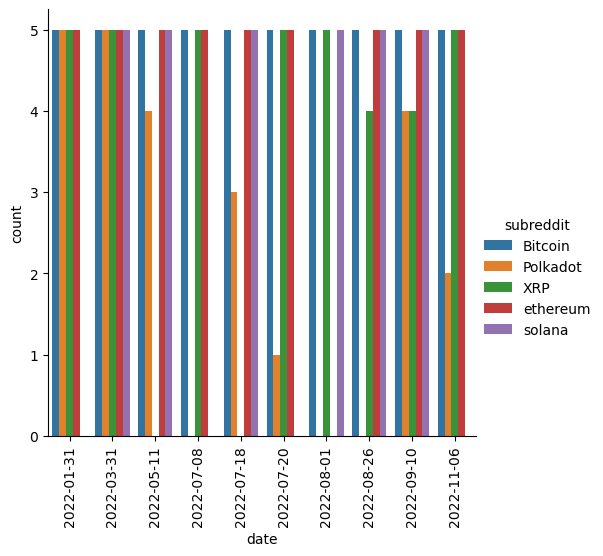

In [7]:
# plot the distribution
sns.catplot(data=for_the_plot, kind="bar",x="date", y="count", hue="subreddit")
plt.xticks(rotation=90)
plt.show()

In [8]:
# convert "for_the_plot" have date as index and subreddit as columns. count as values
for_the_plot = for_the_plot.pivot(index="date", columns="subreddit", values="count")
for_the_plot.to_latex("data/annotation/reddit-counts-per-day.tex")

In [9]:
# Distribution of how often we annoted each category
counts = {annotator:defaultdict(int) for annotator in le_annotators}
for entry in master:
    for annotator in master[entry]["annotations"]:
        for category in master[entry]["annotations"][annotator]:
            counts[annotator][category] += 1
            counts[annotator]["total"] += 1

In [10]:
# numerical values of the counts
for_the_latex = pd.DataFrame()
for annotator in annotators:
    for_the_latex = for_the_latex.append(counts[annotator], ignore_index=True)
for_the_latex.index = annotators
# Divide by total and multiply by 100 to get percentages excluding the total column
for_the_latex = for_the_latex.div(for_the_latex["total"], axis=0).mul(100).drop("total", axis=1)
# round to 2 decimals
for_the_latex = for_the_latex.round(2)
# fill nan with 0
for_the_latex.fillna(0, inplace=True)
# sort the index
for_the_latex.sort_index(inplace=True)
for_the_latex.to_latex("data/annotation/annotation_statistics.tex")


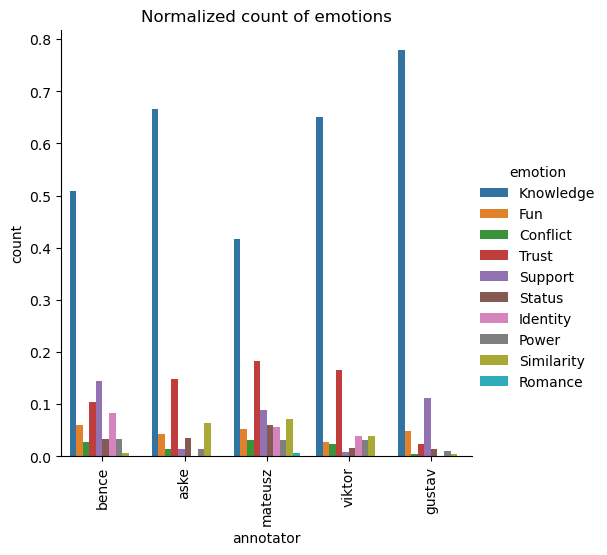

In [11]:
for_the_emotion_plot = pd.DataFrame(columns=["annotator","emotion","count"])
for annotator in counts:
    for emotion in counts[annotator]:
        if emotion != "total":
            for_the_emotion_plot = for_the_emotion_plot.append({"annotator": annotator, "emotion": emotion, "count": counts[annotator][emotion]/counts[annotator]["total"]}, ignore_index=True)
            
# plot the distribution
sns.catplot(data=for_the_emotion_plot, kind="bar",x="annotator", y="count", hue="emotion")
plt.title("Normalized count of emotions")
plt.xticks(rotation=90)
plt.show()

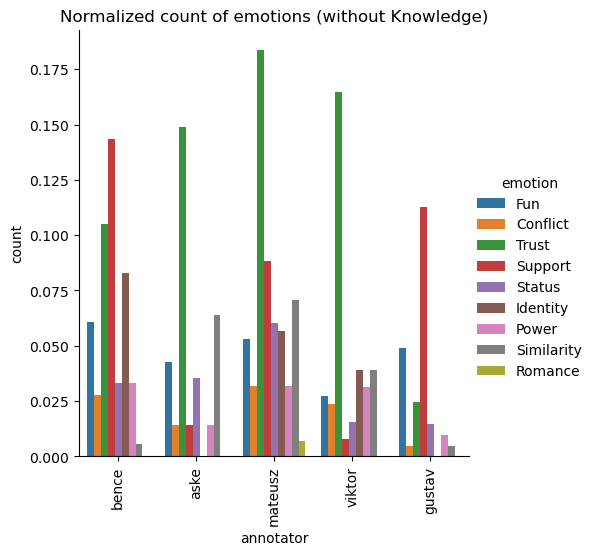

In [12]:
for_the_emotion_plot = pd.DataFrame(columns=["annotator","emotion","count"])
for annotator in counts:
    for emotion in counts[annotator]:
        if emotion not in ["total","Knowledge"]:
            for_the_emotion_plot = for_the_emotion_plot.append({"annotator": annotator, "emotion": emotion, "count": counts[annotator][emotion]/counts[annotator]["total"]}, ignore_index=True)
            
# plot the distribution
sns.catplot(data=for_the_emotion_plot, kind="bar",x="annotator", y="count", hue="emotion")
plt.title("Normalized count of emotions (without Knowledge)")
plt.xticks(rotation=90)
plt.show()